# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet. 

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [29]:
import json
from pprint import pprint
import av
import os
import pprint as pp
from opensearchpy import OpenSearch
from opensearchpy import helpers
import requests
import pickle
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Load both JSON files
with open('captions/val_1.json', 'r') as file1, open('captions/val_2.json', 'r') as file2:
    data1 = json.load(file1)
    data2 = json.load(file2)

In [3]:
def merge_timestamp_dictionaries(ident, dict1, dict2, res = {}):
    # Extract all timestamp-string pairs from both dictionaries
    pairs = []
    dic_ident = "v_" + ident
    # Add pairs from dict1
    for i in range(len(dict1[dic_ident]['timestamps'])):
        pairs.append((dict1[dic_ident]['timestamps'][i], dict1[dic_ident]['sentences'][i]))
    
    # Add pairs from dict2
    for i in range(len(dict2[dic_ident]['timestamps'])):
        pairs.append((dict2[dic_ident]['timestamps'][i], dict2[dic_ident]['sentences'][i]))
    
    # Sort pairs by timestamp
    pairs.sort(key=lambda x: x[0])
    
    # Create new merged dictionary
    res.update({ident: {
        'duration': dict2[dic_ident]["duration"],
        'timestamps': [pair[0] for pair in pairs],
        'sentences': [pair[1] for pair in pairs]
        }
               }
    )
    
    return res

In [4]:
selected_videos_ids = ["QKEFacWrn_8", "_15t4WTR19s", "eXMF6Skt2To", "TNFoUBRsngY", "od1jHUzgrAU", "gXk9TiqGUHs", "IEqnfSiCIXc", "Ez7s36AwgLk", "mHVmDOxtVt0", "i2X7z9ywHV8"]

In [5]:
db = {}

In [6]:
for entry in selected_videos_ids:
    merge_timestamp_dictionaries(entry, data1, data2, db)

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [7]:
video_dir = "videos"
videos = [os.path.join(video_dir, vid) for vid in os.listdir(video_dir) if vid.endswith(".mp4")]

In [8]:
videos

['videos/i2X7z9ywHV8.mp4',
 'videos/mHVmDOxtVt0.mp4',
 'videos/QKEFacWrn_8.mp4',
 'videos/gXk9TiqGUHs.mp4',
 'videos/IEqnfSiCIXc.mp4',
 'videos/od1jHUzgrAU.mp4',
 'videos/TNFoUBRsngY.mp4',
 'videos/Ez7s36AwgLk.mp4',
 'videos/dSdZz_Royyc.mp4',
 'videos/eXMF6Skt2To.mp4',
 'videos/_15t4WTR19s.mp4']

In [9]:
frames = {}
video_dir = "videos"
frames_path = "frames_dict.pkl"

if os.path.exists(frames_path):
    with open(frames_path, 'rb') as f:
        try:
            frames = pickle.load(f)
        except Exception as e:
            print("Error loading pickle file:", e)


if not frames:
    for vid in selected_videos_ids:
        curr_dir = vid + "_keyframes"
        frames_saved = os.path.isdir(curr_dir)
        
        if not frames_saved:
            os.mkdir(curr_dir)
    
        """
        With this implementation we go through every frame and save them if they:
         - are a key frame, or
         - no other frame was saved within that second
    
        On top of that, we create the dictionary frames that contains every frame where:
        - the key is: video_id + "_" + number_of_saved_frame
        - the value is: another dictionary with "timestamp" and "type"
        The type is either sec - for frames saved for the second they are in - or
        key - for being a keyframe.
        """
        with av.open(os.path.join(video_dir, vid + ".mp4")) as container:
            stream = container.streams.video[0]
            last_saved_second = -1
    
            i = 0
            for j, frame in enumerate(container.decode(stream)):
                if frame.pts is None:
                    print("Something wrong here")
                    continue
                
                # Calculate the timestamp in seconds
                timestamp = float(frame.pts * stream.time_base)
                current_second = int(timestamp)
                
                # Check if this is a keyframe
                is_keyframe = frame.key_frame
                
                # Determine if we should save this frame
                save_frame = False
                frame_type = None
                
                if is_keyframe:
                    # Always save keyframes
                    save_frame = True
                    frame_type = "key"
                elif current_second > last_saved_second:
                    # Save non-keyframes only if we don't have a frame for this second yet
                    save_frame = True
                    frame_type = "sec"
                
                if save_frame:
                    i+=1
                    # Update the last second we saved a frame for
                    last_saved_second = current_second
                    
                    # Create a descriptive frame name
                    frame_name = f"{vid}_{i}"
                    name = os.path.join(curr_dir, frame_name + ".jpg")
                    
                    # Update the frames dictionary
                    frames.update({
                        frame_name: {"timestamp": timestamp,
                                     "type": frame_type
                                    }
                    })
                    
                    # Save the frame image if required
                    if not frames_saved:
                        frame.to_image().save(name, quality=80)

    with open(frames_path, 'wb') as f:
        pickle.dump(frames, f)

## Video metadata

Process the video metadata provided in the `json` file and index the video data in OpenSearch.

### Check the current OpenSearch Index

In [26]:
host = 'api.novasearch.org'
port = 443

user = 'user08' # Add your user name here.
password = '55LL.TTSS' # Add your user password here. For testing only. Don't store credentials in code. 
index_name = user

# Create the client with SSL/TLS enabled, but hostname verification disabled.
client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)

locally

In [24]:
# host = 'localhost'
# port = 9200

# # Define the connection to the local OpenSearch server
# client = OpenSearch(
#     hosts = [{'host': host, 'port': port}],
#     http_auth = ('admin', 'JIMMY\neutron509'),  
#     http_compress = True  # Enables gzip compression for request bodies
#     #use_ssl = True,
#     #verify_certs = False,
#     #ssl_assert_hostname = False
# )

# index_name = "wiirijo"  # Replace with your actual index name

# Check if index exists
if client.indices.exists(index=index_name):
    resp = client.indices.open(index=index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index=index_name)
    pp.pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index=index_name)
    pp.pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index=index_name))
else:
    print("Index does not exist.")

{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'wiirijo': {'settings': {'index': {'creation_date': '1744713255323',
                                    'knn': 'true',
                                    'number_of_replicas': '0',
                                    'number_of_shards': '4',
                                    'provided_name': 'wiirijo',
                                    'refresh_interval': '-1',
                                    'replication': {'type': 'DOCUMENT'},
                                    'uuid': 'AeBZuNqaRsq82Gvj_YKS_g',
                                    'version': {'created': '136407927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'wiirijo': {'mappings': {'dynamic': 'strict',
                          'properties': {'caption': {'type': 'text'},
                                         

### Delete Existing Index (if needed)

In [20]:
client.indices.delete(index=index_name, ignore=[400, 404])
print(f"Index '{index_name}' deleted.")

Index 'user08' deleted.


### Creating new index with mappings
Play around here ig

In [21]:
index_body = {
   "settings": {
      "index": {
         "number_of_replicas": 0,
         "number_of_shards": 4,
         # "refresh_interval": "-1", # Keep it off for now, change it to "1s" later (for searching)
         "knn": "true"
      }
   },
   "mappings": {
      "dynamic": "strict",
      "properties": {
         "video_id": {"type": "keyword"},
         "start_timestamp": {"type": "float"},
         "end_timestamp": {"type": "float"},
         "caption": {
            "type": "text",
            "fields": {
               "keyword": {"type": "keyword"}
            }
         },
         "caption_id": {"type": "keyword"},
         "caption_bow": {"type": "text"},
         "caption_vec": {
            "type": "knn_vector",
            "dimension": 768,
            "method": {
               "name": "hnsw",
               "space_type": "innerproduct",
               "engine": "nmslib",
               "parameters": {
                  "m": 16,
                  "ef_construction": 200,
               }
            }
         },
         "duration": {"type": "float"},
         "resolution": {"type": "keyword"},
         "keyframe_path": {"type": "keyword"},
         "keyframe_vec": {
            "type": "knn_vector",
            "dimension": 512,
            "method": {
               "name": "hnsw",
               "space_type": "innerproduct",
               "engine": "nmslib",
               "parameters": {
                  "m": 16,
                  "ef_construction": 200,
               }
            }
         }
      }
   }
}



# Create the index
response = client.indices.create(index=index_name, body=index_body)
print(f"Index '{index_name}' created.")
# Check the index settings
settings = client.indices.get_settings(index=index_name)
print("Index settings:")
pp.pprint(settings)
# Check the index mappings
mappings = client.indices.get_mapping(index=index_name)
print("Index mappings:")
pp.pprint(mappings)

Index 'user08' created.
Index settings:
{'user08': {'settings': {'index': {'creation_date': '1744731493704',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user08',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'XK9CcjL6TPuwZC-yAyL7fA',
                                   'version': {'created': '136387927'}}}}}
Index mappings:
{'user08': {'mappings': {'dynamic': 'strict',
                         'properties': {'caption': {'fields': {'keyword': {'type': 'keyword'}},
                                                    'type': 'text'},
                                        'caption_bow': {'type': 'text'},
                                        'caption_id': {'type': 'keyword'},
                                        'caption_vec': {'dimension

## Video captions

The ActivityNetCaptions dataset https://cs.stanford.edu/people/ranjaykrishna/densevid/ dataset provides a textual description of each videos. Index the video captions on a text field of your OpenSearch index.

### Generating embeddings for Captions

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the pre-trained model and tokenizer
model_name = 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
model = AutoModel.from_pretrained(model_name, config = config)
model.eval()  # Set the model to evaluation mode

print(f"Loaded model type: {type(model)}") 

def generate_caption_embedding(caption):
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)  # Pass the entire dictionary
        # Mean pooling
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings
    

Loaded model type: <class 'transformers.models.mpnet.modeling_mpnet.MPNetModel'>


In [18]:
def generate_caption_embedding_outputs(caption):
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)  # Pass the entire dictionary
    return inputs, outputs

### Generate embeddings for Keyframes

dependency:

pip install openai-clip

In [13]:
from PIL import Image
import torch
import open_clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
clip_model.to(device)
clip_model.eval()

def generate_keyframe_embedding(image_path):
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
        embedding_vector = image_features.cpu().numpy().flatten()
        if len(embedding_vector) == 0:
            print(f"Failed to generate embedding for {image_path}")
            return None
        return embedding_vector
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


/home/gigag/Documents/mpdw/1env/lib/python3.12/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


### Indexing Data

locally

In [22]:
# Get the activity dataset
with open('activity_net.v1-3.min.json', 'r') as json_data:
    activity_data = json.load(json_data)
# Specify the index name you want to check
# index_name = "wiirijo"

# Get document count for the index
doc_count = client.count(index=index_name)

if doc_count['count'] > 0:
    print("Are you sure documents arent already indexed?")
else:
    # Cycle through the videos
    for video_id in selected_videos_ids:
        video_info = db[video_id]
        duration = video_info["duration"]
        timestamps = video_info["timestamps"]
        captions = video_info["sentences"]
        resolution = activity_data["database"][video_id]["resolution"]
        keyframe_dir = video_id + "_keyframes"
        keyframes = [os.path.splitext(f)[0] for f in os.listdir(keyframe_dir)]
    
        # Cycle through the video keyframes
        for frame_name in keyframes:
    
            kf_timestamp = frames[frame_name]["timestamp"]
    
            for i in range(len(timestamps)):
    
                start_time, end_time = timestamps[i]
    
                if start_time <= kf_timestamp <= end_time:
                    
                    caption = captions[i]
                    caption_embedding = generate_caption_embedding(caption)
                    caption_bow = caption.split()
                    caption_vec = caption_embedding.tolist()
                    keyframe_path = os.path.join(keyframe_dir, frame_name + ".jpg")
                    keyframe_embedding = generate_keyframe_embedding(keyframe_path)
                    keyframe_vec = keyframe_embedding.tolist()
                    
                    caption_id = f"{video_id}_{start_time}_{end_time}"
                    
                    document_id = f"{caption_id}_{frame_name}"
                    
                    doc = {
                            'video_id': video_id,
                            'start_timestamp': start_time,
                            'end_timestamp': end_time,
                            'caption': caption,
                            'caption_id': caption_id,
                            'caption_bow': caption_bow,
                            'caption_vec': caption_vec,
                            'duration': duration,
                            'resolution': resolution,
                            'keyframe_path': keyframe_path,
                            'keyframe_vec': keyframe_vec
                        }
                    
                    try:
                        response = client.index(index=index_name, id=document_id, body=doc)
                        #print(f"Indexed document for keyframe {frame_name} with caption '{caption}'")
                    except Exception as e:
                        print(f"Error indexing document for video {video_id}: {e}")
                        continue

    # Refresh the index to make the documents searchable
    client.indices.refresh(index=index_name)
    print("Index refreshed.")

Index refreshed.


# Testing

## Search the Index

In [27]:
# Specify the index name you want to check
# index_name = "wiirijo"

# Get document count for the index
doc_count = client.count(index=index_name)

# Print the document count
print(f"Number of documents in {index_name}: {doc_count['count']}")

Number of documents in user08: 5967


### Text-based search

In [24]:
query = {
    "query": {
        "match": {
            "caption": "skateboarding in a park"
        }
    }
}

response = client.search(index=index_name, body=query)
print("Search Results:")
for hit in response['hits']['hits']:
    print(f"Caption: {hit['_source']['caption']}, Score: {hit['_score']}")

Search Results:
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.223228
Caption: A man is skating in a skate park., Score: 8.070235
Caption: A man is skating in a skate park., Score: 8.070235
Caption: A man is skating in a skate park., Score: 8.070235
Caption: A man is skating in a skate park., Score: 8.070235


## Semantic Search with KNN Vectors

In [25]:
import torch
from transformers import AutoTokenizer, AutoModel

# Generate embedding for your query
query_text = "A man skateboarding on a park"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Construct the query for OpenSearch
query = {
    "query": {
        "knn": {
            "caption_vec": {
                "vector": query_embedding.tolist(),
                "k": 5  # Number of nearest neighbors to retrieve
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("KNN Search Results:")
for hit in response['hits']['hits']:
    print(f"Caption: {hit['_source']['caption']}, Score: {hit['_score']}")


/home/wiirijo/anaconda3/envs/mpdw/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KNN Search Results:
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288
Caption: A man is skating in a skate park., Score: 7.110288


For distinct results

In [26]:
import torch
from transformers import AutoTokenizer, AutoModel

# Generate embedding for your query
query_text = "skateboarding"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Construct the query for OpenSearch
query = {
    "query": {
        "knn": {
            "caption_vec": {
                "vector": query_embedding.tolist(),
                "k": 10  # Number of nearest neighbors to retrieve
            }
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("Distinct KNN Search Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")

Distinct KNN Search Results:
Caption:  Men attempt various tricks using bowling balls., Count: 73
Caption:  Other person skates on a park, then pass over the rails and turning and flipping teh skateboard., Count: 32
Caption:   A man knocks down pins in a skating pool drop in., Count: 12
Caption:  We see skating for awhile., Count: 8
Caption:  After, a man interview a male using a microphone., Count: 6
Caption:  Then, people talks in a bowling center, wile males trowing bowling bowls., Count: 6
Caption: People are on front a board in a park holding bowling pins., Count: 5
Caption: The video starts with footage of people outside with red,white and blue text explaining what the video is about., Count: 5
Caption:   A bowling ball in a skate drop breaks something inside the drop., Count: 3
Caption:   One man shows another how to hold the bowling ball., Count: 3


## Boolean filters

In [27]:
bool_query = {
    "query": {
        "bool": {
            "filter": [
                {"term": {"resolution": "1920x1080"}},
                {
                    "range": {
                        "start_timestamp": {
                            "gte": 60,
                            "lte": 70
                        }
                    }
                }
            ]
            
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=bool_query)
print("Distinct Boolean Query Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")


Distinct Boolean Query Results:
Caption: When he removes his hand from his throat,he takes another puff of the hookah and blows it out again., Count: 53
Caption:  We see the man boxing with another man., Count: 46
Caption:  The man uses the polish on his shoes., Count: 39
Caption:  He then gets fully dressed, noticing his trembling feet., Count: 14


## Mixing embedding search + filters

In [28]:
query_text = "smoking"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

query = {
    "query": {
        "bool": {
            "must": [  # Combine KNN search with other filters
                {
                    "knn": {
                        "caption_vec": {
                            "vector": query_embedding.tolist(),
                            "k": 10  # Number of nearest neighbors to retrieve
                        }
                    }
                }
            ],
            "filter": [  # Apply filters before the KNN search
                {"term": {"resolution": "1920x1080"}},
                {"range": {"duration": {"gte": 150}}}
            ]
        }
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

response = client.search(index=index_name, body=query)
print("Filtered KNN Search Results:")
for bucket in response['aggregations']['distinct_captions']['buckets']:
    print(f"Caption: {bucket['key']}, Count: {bucket['doc_count']}")


Filtered KNN Search Results:
Caption:  The man blows circles in the smoke., Count: 28
Caption: We see a man smoking a hookah pipe and talking to the camera., Count: 12


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from opensearchpy import OpenSearch
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [29]:
embedding_field = "caption_vec"  # Replace with your actual field name
sample_size = 1000  # Adjust based on your dataset size and computational resources

In [40]:
query = {
    "size": sample_size,
    "_source": [embedding_field, "caption"],
    "query": {
        "match_all": {}
    },
    "aggs": {
        "distinct_captions": {
            "terms": {
                "field": "caption.keyword",
                "size": 10
            }
        }
    }
}

In [41]:
# Execute the query
response = client.search(
    body=query,
    index=index_name
)

In [32]:
# Extract embeddings and captions
embeddings = []
captions = []
for hit in response['hits']['hits']:
    embedding = hit['_source'][embedding_field]
    caption = hit['_source']['caption']
    embeddings.append(embedding)
    captions.append(caption)

In [34]:
embeddings_array = np.array(embeddings)
print(f"Loaded {len(embeddings_array)} embeddings with dimension {embeddings_array.shape[1]}")

Loaded 1000 embeddings with dimension 768


## Embeddings

In [9]:
captions = []
for ident in selected_videos_ids:
    for sent in db[ident]["sentences"]:
        captions.append(sent)

In [10]:
captions[3]

' A man is in a skateboard track, then he throws a bowling ball that goes around and hits the pins.'

In [ ]:
def generate_all_embeddings_graph(sentences):
    ins, outs = generate_caption_embedding_outputs(sentence)
    input_ids = ins['input_ids']
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    layer_m = 11
    output_embeddings = outs['hidden_states'][layer_m][0]
    fig = visualize_hidden_states(hidden_states, tokens)

In [19]:
ins, outs = generate_caption_embedding_outputs(captions[3])

In [20]:
outs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [16]:
# total number of layers embeddings
len(outs['hidden_states'])

13

In [43]:
input_ids = ins['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
layer_m = 11
output_embeddings = outs['hidden_states'][layer_m][0]

In [38]:
f.write_html("interactive_embeddings.html")

In [50]:
def visualize_hidden_states(hidden_states, tokens, output_path=None, dpi=150):
    """
    Create a multi-panel plot of hidden states across different layers,
    and save it to a file if output_path is provided.
    
    Parameters:
    - hidden_states: List of hidden state tensors from different layers
    - tokens: List of token strings
    - output_path: Path to save the figure (optional)
    - dpi: Resolution for saved image (higher values = larger file, better quality)
    
    Returns:
    - fig: The matplotlib figure object
    """
    rows = 3
    cols = 4
    num_layers = min(rows * cols, len(hidden_states))
    
    # Create figure and subplots
    fig, ax_full = plt.subplots(rows, cols, figsize=(cols*4+3, rows*4))
    plt.rcParams.update({'font.size': 10})
    
    # Plot each layer
    layer = 0
    for r in range(rows):
        for c in range(cols):
            if layer >= num_layers:
                # Hide unused subplots
                ax_full[r, c].axis('off')
                continue
                
            ax = ax_full[r, c]
            
            # Get current hidden state and convert to numpy if needed
            current_hidden_state = hidden_states[layer][0]
            if hasattr(current_hidden_state, 'detach'):
                current_hidden_state = current_hidden_state.detach().numpy()
            
            # Apply PCA if needed
            if current_hidden_state.shape[1] == 2:
                twodim = current_hidden_state
            else:
                twodim = PCA().fit_transform(current_hidden_state)[:, :2]
            
            # Create scatter plot
            ax.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
            
            # Add text labels
            for word, (x, y) in zip(tokens, twodim):
                # Clean token if needed (removing special characters)
                token_text = word[1:] if word.startswith(('#', '@', '!')) else word
                ax.text(x+0.05, y+0.05, token_text)
            
            # Set title for this subplot
            ax.set_title(f"Layer {layer}", fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Increment layer counter
            layer += 1
    
    # Add overall title
    fig.suptitle("Visualization of Output Embeddings Across All Layers", 
                fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    # Save figure if output path is provided
    if output_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path) if os.path.dirname(output_path) else '.', 
                   exist_ok=True)
        
        # Save with different formats based on extension
        extension = os.path.splitext(output_path)[1].lower()
        
        if extension == '.png':
            fig.savefig(output_path, dpi=dpi, bbox_inches='tight')
        elif extension == '.pdf':
            fig.savefig(output_path, format='pdf', bbox_inches='tight')
        elif extension == '.svg':
            fig.savefig(output_path, format='svg', bbox_inches='tight')
        elif extension == '.jpg' or extension == '.jpeg':
            fig.savefig(output_path, format='jpg', dpi=dpi, bbox_inches='tight', 
                       quality=95, optimize=True)
        else:
            # Default to PNG if extension not recognized
            fig.savefig(output_path + '.png', dpi=dpi, bbox_inches='tight')
            
        print(f"Figure saved to {output_path}")
    
    # Return the figure object
    return fig

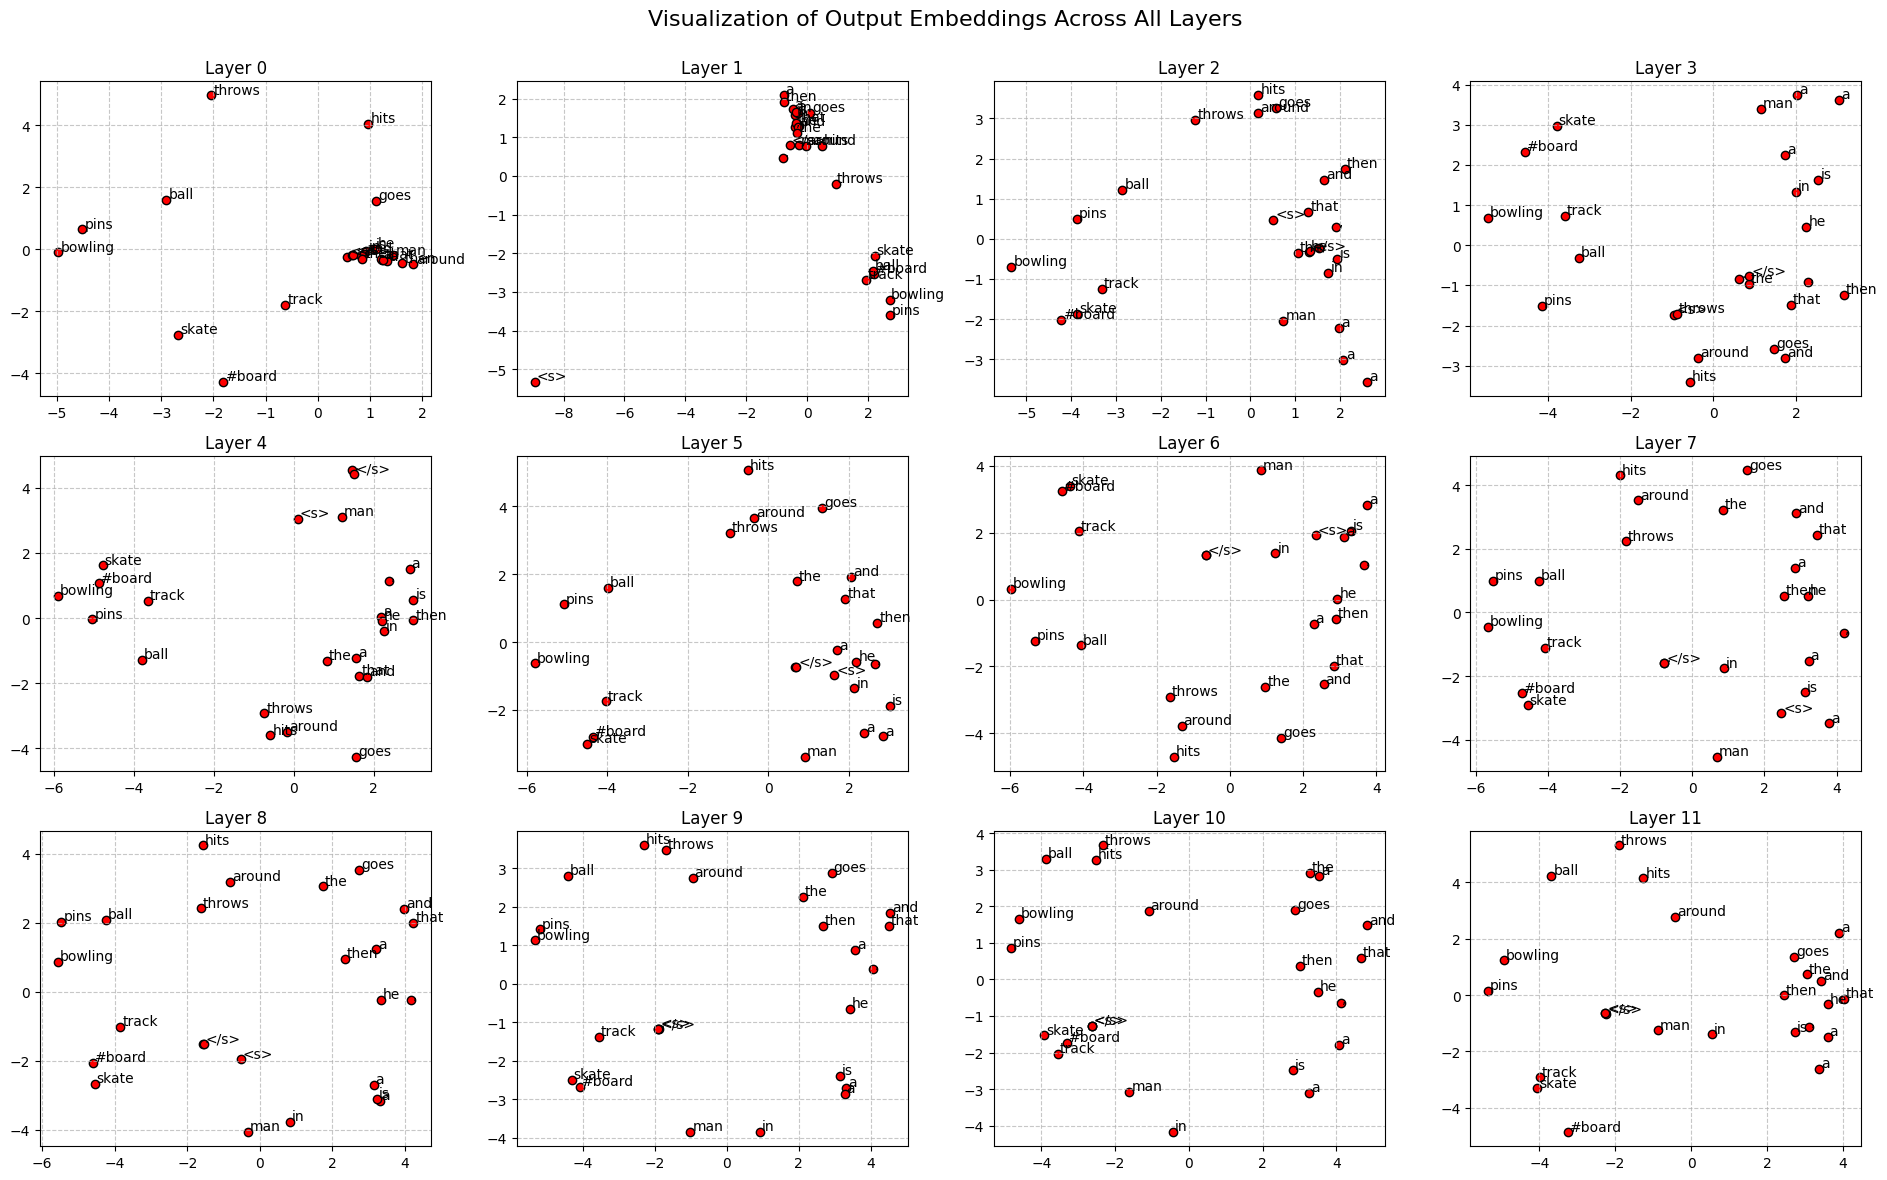

In [54]:
fig = visualize_hidden_states(hidden_states, tokens)

In [55]:
fig.savefig("hidden_layers.png")

In [61]:
ins, outs = generate_caption_embedding_outputs("ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball ball")

In [75]:
input_ids = ins['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
output_embeddings = outs.last_hidden_state[0]

In [89]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def display_scatterplot(data, words, filename="scatterplot.png"):
    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(data)
        twodim = pca.transform(data)[:, :2]
    
    plt.style.use('default')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)
    
    plt.xlim(-1, 1)  # Set x-axis range
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot
    plt.close()  # Prevent re-display in some environments

display_scatterplot(output_embeddings.detach().numpy(), tokens, "pos_embeds.png")

In [88]:
plt.show()

In [80]:
output_embeddings.detach().numpy()

array([[-0.10207481, -0.08822922,  0.03056179, ...,  0.03742896,
        -0.03212436, -0.00422881],
       [-0.11881364,  0.02497547, -0.01503671, ...,  0.10516781,
        -0.03160025, -0.01068128],
       [-0.14782523,  0.04355097,  0.00583182, ...,  0.09683295,
        -0.05589344, -0.01374314],
       ...,
       [-0.1699806 ,  0.15894663,  0.03388931, ...,  0.06924164,
        -0.06251905,  0.02850354],
       [-0.17195293,  0.23085742,  0.04460301, ...,  0.06523876,
        -0.06394424, -0.00177262],
       [-0.11823333, -0.09104094,  0.1055546 , ...,  0.00331477,
        -0.09950992,  0.00708322]], shape=(21, 768), dtype=float32)